# Theory
VRP : https://developers.google.com/optimization/routing/vrp \
CVRP : https://developers.google.com/optimization/routing/cvrp#python

In [7]:
import networkx as nx
import numpy as np

from ortools.sat.python import cp_model
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from random import randint, sample, seed

from scripts.cvrp import TestCVRP, border_hubs

In [2]:
from scripts.graph_filtration.utils import plot_simplex
from scripts import graph_osm_loader


CITY = 'ASHA'
GRAPH_ID = graph_osm_loader.cities[CITY] # KRG

# примеры id есть в graph_osm_loader.py
G = graph_osm_loader.get_graph(GRAPH_ID) # загрузка графа

pos = {u: [d['x'], d['y']] for u,d in G.nodes(data=True)} 

K = [
        list(G.nodes), # dim = 0 : vertices
        list(G.edges), # dim = 1 : edges
    ]

## Leiden

In [3]:
from scripts.graph_filtration.utils import plot_simplex
from scripts import clustering
import leidenalg as la


# get clusters
# clusters = clustering.leiden(G, partition_type=la.CPMVertexPartition, resolution_parameter = 0.2, seed=0, weights='length')
clusters = clustering.filtration_clustering(G)[4]

 10%|█         | 1/10 [00:00<00:02,  3.79it/s]

100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


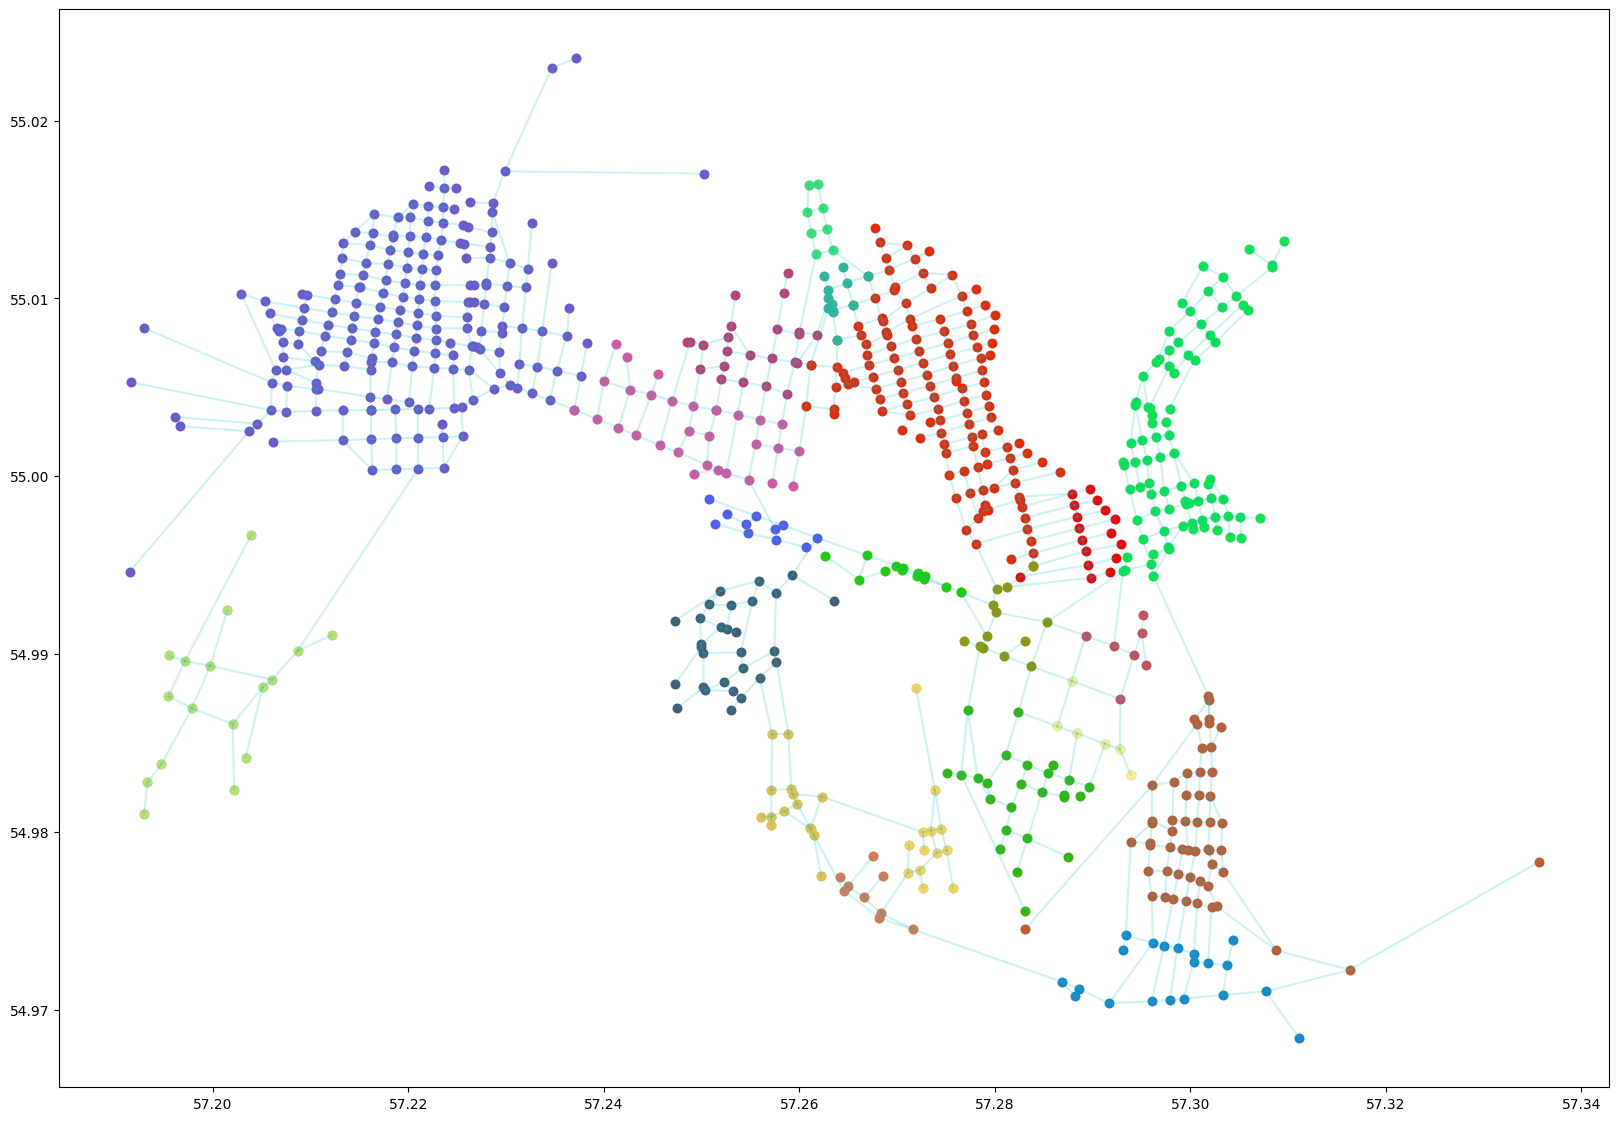

In [4]:
plt.figure(figsize=(20, 14))

plot_simplex(pos, K, alpha=0.6)
for j, cluster in enumerate(clusters):
    color = '#%06X' % randint(0, 0xFFFFFF)
    for v in cluster:
        point = pos[v]
        plt.scatter(point[0], point[1], c=color)

plt.show()

# Border strategy


In [5]:
from collections import defaultdict
from ortools.sat.python import cp_model


# def border_hubs(clusters, max_size, num_workers=None, time_limit=None, verbose=False):
#     # -------------------
#     # Part 1: preparation
#     # Label all nodes according to their clusters
#     clusters_labels = {i : c for i, c in enumerate(clusters)}
#     nodes_labels = {}
#     for i, c in enumerate(clusters):
#         for v in c:
#             nodes_labels[v] = i

#     # Find border nodes
#     border = {}
#     for i, cluster in enumerate(clusters):
#         for v in cluster:
#             # 1-hop neighbour
#             for hop_1 ,_ in G._adj[v].items():
#                 if nodes_labels[hop_1] != i:
#                     if v not in border:
#                         border[v] = set([nodes_labels[v]])
#                     # Store what kind of clusters are nearby
#                     border[v].add(nodes_labels[hop_1])
                
#                 if v in border:
#                     # 2-hop neighbour
#                     for hop_2 ,_ in G._adj[hop_1].items():
#                         if nodes_labels[hop_2] != i:
#                             if v not in border:
#                                 border[v] = set([nodes_labels[v]])
#                             # Store what kind of clusters are nearby
#                             border[v].add(nodes_labels[hop_2])

#     # Filter out points, whose combinations are too large
#     erase_list = []
#     for v in border:    
#         combination_size = 0
#         for label in border[v]:
#             combination_size += len(clusters[label])
        
#         if max_size and combination_size > max_size:
#             erase_list.append(v)

#     for v in erase_list:
#         border.pop(v)

#     # Collect combinations of neighbours
#     cluster_combinations = defaultdict(lambda: set())
#     for v in border:
#         combination = tuple(sorted(border[v]))
#         cluster_combinations[combination].add(v)

#     # Find among them the one, with smallest distance to the whole set
#     for combination in cluster_combinations:
#         # Get union of all nodes from corresponding clusters
#         cluster_union = set()
#         for i in combination:
#             cluster_union.update(clusters_labels[i])
#         G_cluster = nx.subgraph(G, cluster_union)

#         if len(cluster_combinations[combination]) > 1:
#             # Search for node with minimal distance
#             min_dist = np.inf
#             for v in cluster_combinations[combination]:
#                 d = dict(nx.single_source_dijkstra_path_length(G_cluster, v, weight='length'))
#                 d_sum = np.sum([d[v] for v in d])
#                 if d_sum < min_dist:
#                     d_mean = np.mean([d[v] for v in d])
#                     border_hub = v
#                     min_dist = d_sum

#             cluster_combinations[combination] = (border_hub, d_mean)
#         else:
#             v = list(cluster_combinations[combination])[0]
#             d = dict(nx.single_source_dijkstra_path_length(G_cluster, v, weight='length'))
#             d_mean = np.mean([d[v] for v in d])
#             cluster_combinations[combination] = (border_hub, d_mean)

#     # Now add variants with just centroids
#     # centroid_hubs = [None for i in range(len(clusters_labels))]
#     for i in clusters_labels:
#         G_cluster = G.subgraph(clusters_labels[i])
#         hub = nx.barycenter(G_cluster, weight='length')[0]
#         d = dict(nx.single_source_dijkstra_path_length(G_cluster, hub, weight='length'))
#         d_mean = np.mean([d[v] for v in d])
#         # cluster_combinations[i] = (hub, d_mean)
#         cluster_combinations[tuple([i])] = (hub, d_mean)

#     # --------------------------------
#     # Part 2: finding optimal solution
#     # Init optimization model
#     model = cp_model.CpModel()
#     # Store combinations as binary vectors
#     Covers = np.zeros((len(cluster_combinations), len(clusters)))
#     for i, combination in enumerate(cluster_combinations):
#         for j in combination:
#             Covers[i][j] = 1
#     # Store mean distances as one vector
#     Costs = np.array([d[-1] for _, d in cluster_combinations.items()])
#     # Some dimension parameters
#     N = len(clusters) # len of universe
#     P = len(cluster_combinations) # number of sets
#     # Variable to store the solution
#     Set_cover = {}

#     # Each set is a binary vector: [0,0,1,0,1,...]
#     for p in range(P):
#         Set_cover[p] = model.new_bool_var(name=f'cover_{p}')

#     # Sum should give precisely [1,1,1,1,1,...]
#     for i in range(N):
#         model.add(sum(Set_cover[p] * Covers[p][i] for p in range(P)) == 1)

#     # Minimize distance
#     objective_func = sum(Set_cover[p] * Costs[p] for p in range(P))
#     model.minimize(objective_func)

#     solver = cp_model.CpSolver()
#     if num_workers:
#         solver.parameters.num_workers = num_workers
#     solver.parameters.log_search_progress = verbose
#     if time_limit:
#         solver.parameters.max_time_in_seconds = 60.0 * time_limit # in minutes
    
#     status = solver.solve(model)

#     status_codes = {
#                 cp_model.UNKNOWN : 'UNKNOWN',
#                 cp_model.MODEL_INVALID : 'MODEL_INVALID',
#                 cp_model.FEASIBLE : 'FEASIBLE',
#                 cp_model.INFEASIBLE : 'INFEASIBLE',
#                 cp_model.OPTIMAL : 'OPTIMAL'
#             }

#     optimal_combination = []
#     solver_solution = [solver.value(v) for v in Set_cover.values()]
#     for i, cover in enumerate(cluster_combinations):
#         if solver_solution[i]:
#             optimal_combination.append(cover)

#     if verbose:
#         print(f'Solution status: {status_codes[status]}')
#         print(f'Optimal combination: {optimal_combination}')
#         print(f'Total mean distance: {solver.value(objective_func)}')
    
#     optimal_hubs = []
#     for combination in optimal_combination:
#         optimal_hubs.append(cluster_combinations[combination][0])
    
#     return optimal_hubs

In [8]:
total_hubs = border_hubs(G, clusters, max_size=300, verbose=True)


Starting CP-SAT solver v9.11.4210
Parameters: log_search_progress: true
Setting number of workers to 32

Initial optimization model '': (model_fingerprint: 0x11872d63044c0925)
#Variables: 55 (#bools: 55 in floating point objective)
  - 55 Booleans in [0,1]
#kLinear2: 1
#kLinear3: 4
#kLinearN: 16 (#terms: 94)

Starting presolve at 0.00s
[Scaling] Floating point objective has 55 terms with magnitude in [162.434, 1593.01] average = 746.723
[Scaling] Objective coefficient relative error: 1.22319e-08
[Scaling] Objective worst-case absolute error: 5.2723e-05
[Scaling] Objective scaling factor: 131072
  5.08e-05s  0.00e+00d  [DetectDominanceRelations] 
  1.91e-05s  0.00e+00d  [DetectDominanceRelations] 
  3.15e-04s  0.00e+00d  [PresolveToFixPoint] #num_loops=4 #num_dual_strengthening=3 
  8.32e-06s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=12 
[Symmetry] Graph for symmetry has 76 nodes and 48 arcs.
[Symmetry] Symmetry computation done. time: 2.4692e-05 dtime: 6.93e-06
  2.

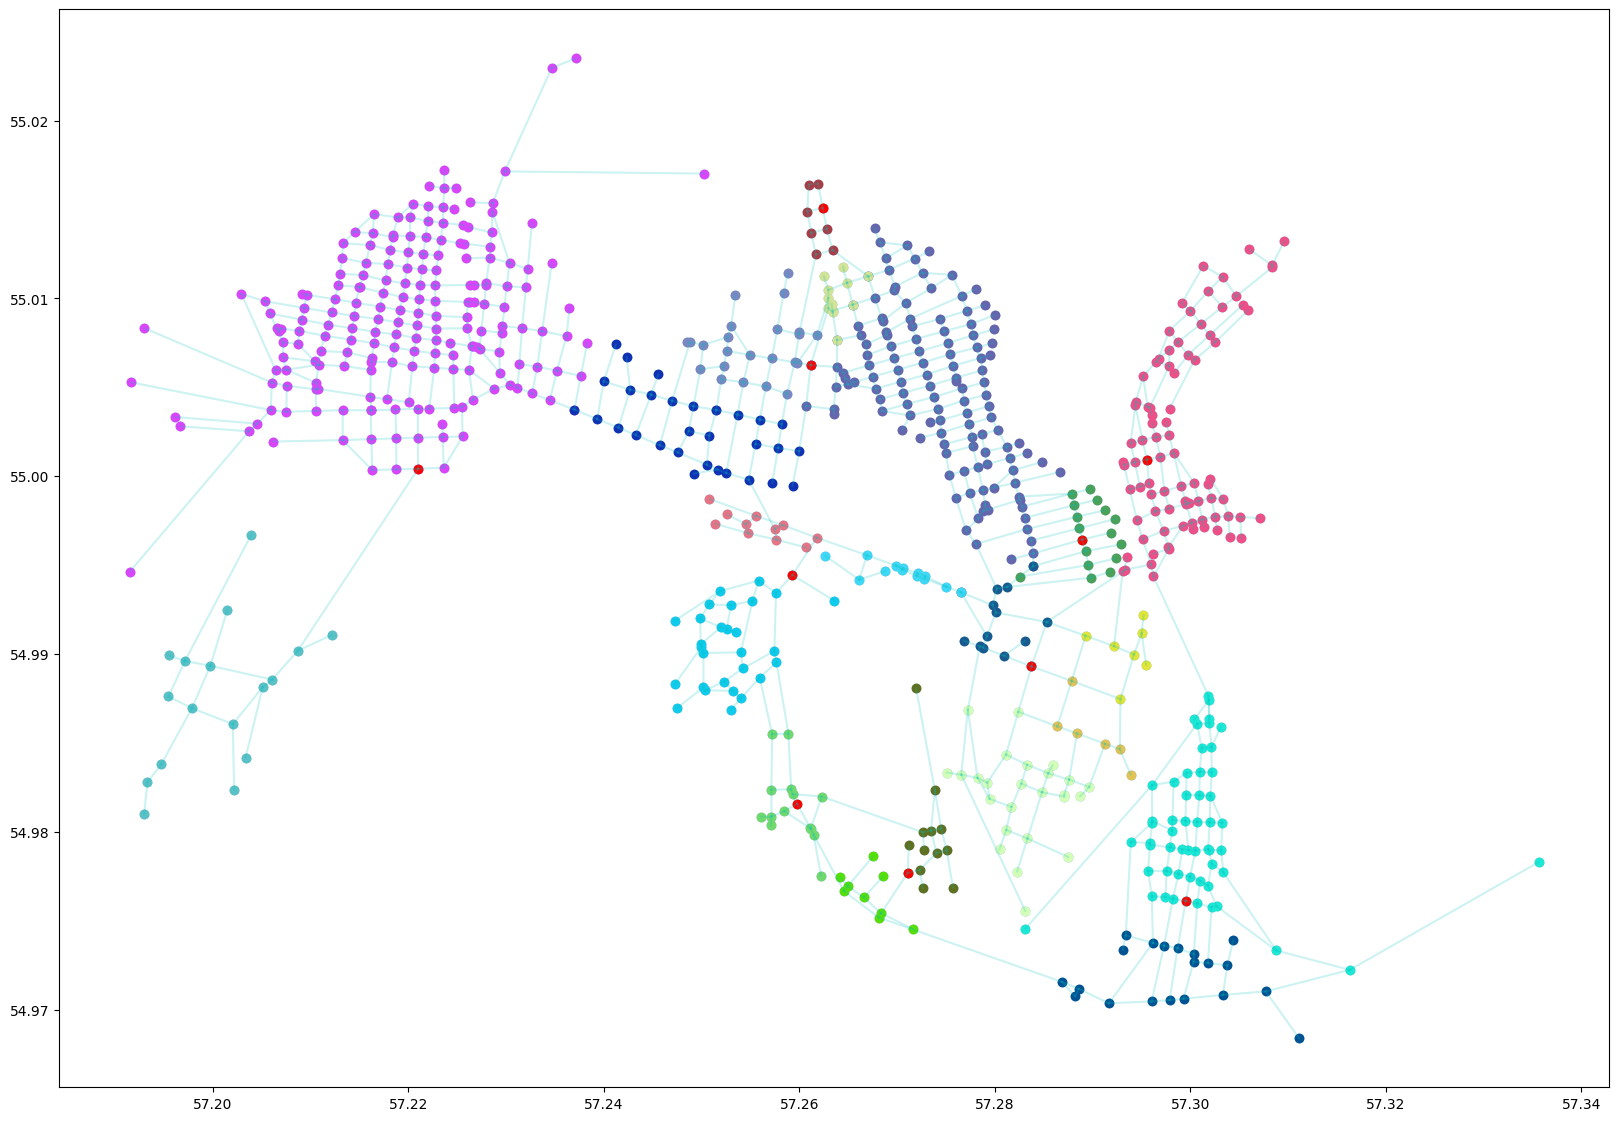

In [9]:
plt.figure(figsize=(20, 14))

plot_simplex(pos, K, alpha=0.6)

for j, cluster in enumerate(clusters):
    color = '#%06X' % randint(0, 0xFFFFFF)
    for v in cluster:
        point = pos[v]
        plt.scatter(point[0], point[1], c=color)

# for _, v in cluster_combinations.items():
#     point = pos[v[0]]
#     plt.scatter(point[0], point[1], c='yellow')

for v in total_hubs:
    point = pos[v]
    plt.scatter(point[0], point[1], c='red')

# Centralitites
## Centrality per cluster

In [80]:
def cluster_aggregation_strategy(G, clusters, aggregation, weight='length'):
    hubs = []
    d_means = []
    for c in clusters:
        G_cluster = G.subgraph(c)
        hub = aggregation(G_cluster, weight)
        hubs.append(hub)
        # mean distance
        d = dict(nx.single_source_dijkstra_path_length(G_cluster, hub, weight=weight))
        d_mean = np.mean([d[v] for v in d])
        d_means.append(d_mean)
    return hubs, d_means

In [87]:
def wrap_weight(G, weight, func):
    results = func(G, weight=weight)
    return max(results, key=results.get)

def wrap_distance(G, weight, func):
    results = func(G, distance=weight)
    return max(results, key=results.get)

In [94]:
# Weight
centralities = {
    # nx.katz_centrality : 'katz', 
    nx.eigenvector_centrality_numpy : 'eigen',
    nx.current_flow_closeness_centrality : 'curr_flow',
    nx.information_centrality: 'info_flow',
    nx.betweenness_centrality: 'betweenness',
    nx.load_centrality: 'load',
    nx.percolation_centrality : 'percolation'
 }

for func, name in centralities.items():
    hubs, d_means = cluster_aggregation_strategy(G, clusters, 
                                                 lambda G, w: wrap_weight(G, w, func), 
                                                 weight='length')
    print(f'{name} : {np.sum(d_means)}')

eigen : 13785.141375814468
info_flow : 9044.943567676777
betweenness : 9044.224738590441
load : 9044.224738590441
percolation : 9044.224738590441


In [93]:
centralities = {nx.closeness_centrality : 'closeness',
 }

for func, name in centralities.items():
    hubs, d_means = cluster_aggregation_strategy(G, clusters, 
                                                 lambda G, w: wrap_distance(G, w, func), 
                                                 weight='length')
    print(f'{name} : {np.sum(d_means)}')

closeness : 8607.487294650991


## Cluster on top of chosen central nodes